In [ ]:
%pip install lightning
%pip install timm
%pip install astropy
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold

import sys
sys.path.append('/content/')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Hyper-parameters
input_size = 224*224
# hidden_size = 166
hidden_size = 166
num_epochs = 10
batch_size = 2
learning_rate = 0.002
dropout = 0.5

k_folds = 5

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
dataset = SunImageDataset(csv_file="/content/dataset_collab_full_3days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_collab_full_3days.csv")
kp_dates_list = kp_dates["date"].tolist()

1097
1097
1097
1097
1099


In [ ]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_collab_full_3days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

271
302
417
422
318


In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )


        # Fully connected layers
        self.fc = nn.Sequential(
            # nn.Linear(hidden_size*10, hidden_size*5),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*10, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()
        )

    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, -1)

        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# model, optimizer = fabric.setup(model, optimizer)
model.train()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

GmiSwinTransformer(
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pretrained_model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwi

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()

              # Forward pass with autograd
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              # print("Label: ", labels)
              outputs = model(images).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.25151103429002


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7291410467799462


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.9111117246929887


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9324519536084748


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.886593495935957


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8196873353329404


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.841620360819118


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.694697027055645


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8159658394630889


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7129964102738162


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8172997064379326


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.757197731878534


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8134398772319724


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7484990524871102


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8051917150679229


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7063671917652878


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8108842757685377


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.72571556140857


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8054910885461937


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.743631139085484


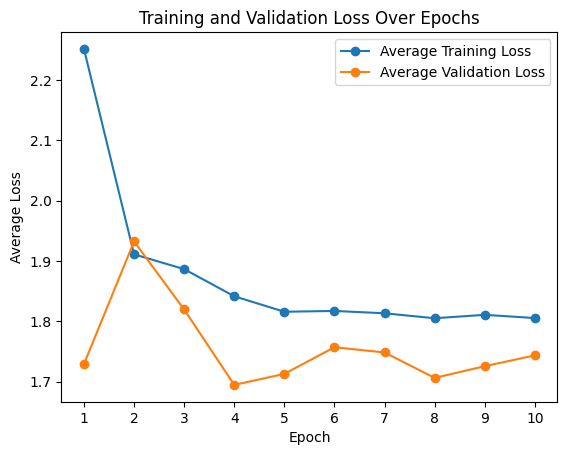

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.7436
RMSE: 1.3205
MSE: 1.7425
MAE: 1.0366
R²: -0.0339
R: 0.0768
True Skill Score: 0.0000
Accuracy: 0.7530
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


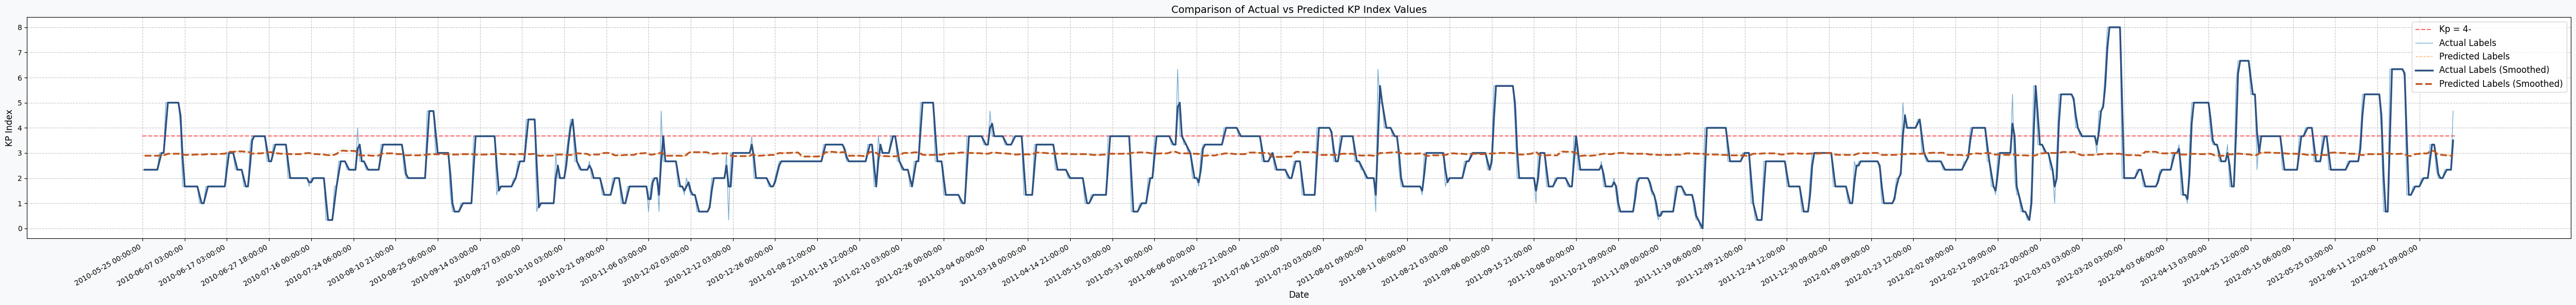

[np.float32(2.890625), np.float32(2.890625), np.float32(2.890625), np.float32(2.890625), np.float32(2.890625), np.float32(2.890625), np.float32(2.890625), np.float32(2.890625), np.float32(2.90625), np.float32(2.90625), np.float32(2.90625), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(2.984375), np.float32(2.921875), np.float32(2.921875), np.float32(2.921875), np.float32(2.9375), np.float32(2.921875), np.float32(2.9375), np.float32(2.9375), np.float32(2.9375), np.float32(2.9375), np.float32(2.9375), np.float32(2.9375), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(3.046875), np.float32(3.046875), np.float32(3.046875), np.float32(3.046875), np.float32(3.0625), np.float32(3.0625), np.float32(3.0625)

Testing Progress:   0%|          | 0/136 [00:00<?, ?it/s]

Average test loss: 3.1702
RMSE: 1.7805
MSE: 3.1802
MAE: 1.4644
R²: -2.0695
R: 0.0212


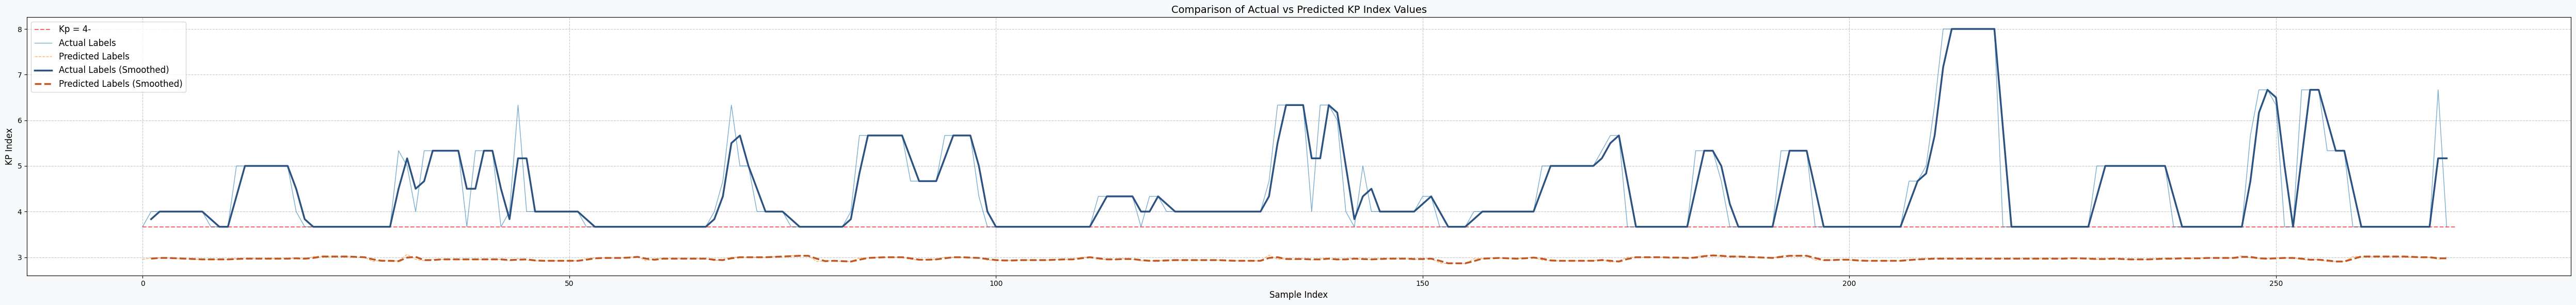

[np.float32(2.953125), np.float32(2.984375), np.float32(2.984375), np.float32(2.984375), np.float32(2.96875), np.float32(2.96875), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(2.96875), np.float32(2.984375), np.float32(2.953125), np.float32(3.015625), np.float32(3.015625), np.float32(3.015625), np.float32(3.015625), np.float32(3.015625), np.float32(3.0), np.float32(3.0), np.float32(2.90625), np.float32(2.9375), np.float32(2.90625), np.float32(2.921875), np.float32(3.0625), np.float32(2.953125), np.float32(2.921875), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.953125), np.float32(2.921875), np.float32(2.96875), np.float32(2.9375), np.float32(2.92

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.0977397294114675


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.275645632223007


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.4053839559987684


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8977893557058536


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9694639237045474


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8339212932498814


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7426846267940563


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0918965394102833


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5878952270901416


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1000723822487863


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.44798563473990793


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0818287289802866


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.38054833688756246


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8402460730275843


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.30398731450201544


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.311386139585352


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.27363952091454974


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9695508721520367


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.24486347696939678


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0560551003834218


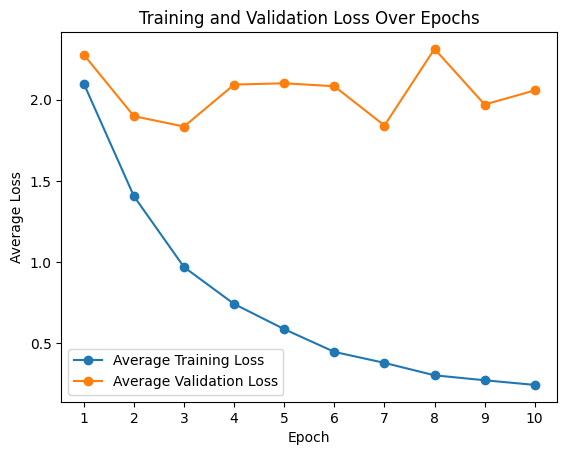

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.0561
RMSE: 1.4339
MSE: 2.0579
MAE: 1.1535
R²: -0.0644
R: 0.2228
True Skill Score: 0.4453
Accuracy: 0.7338
Precision: 0.5333
Recall: 0.2649
F1 Score: 0.3540


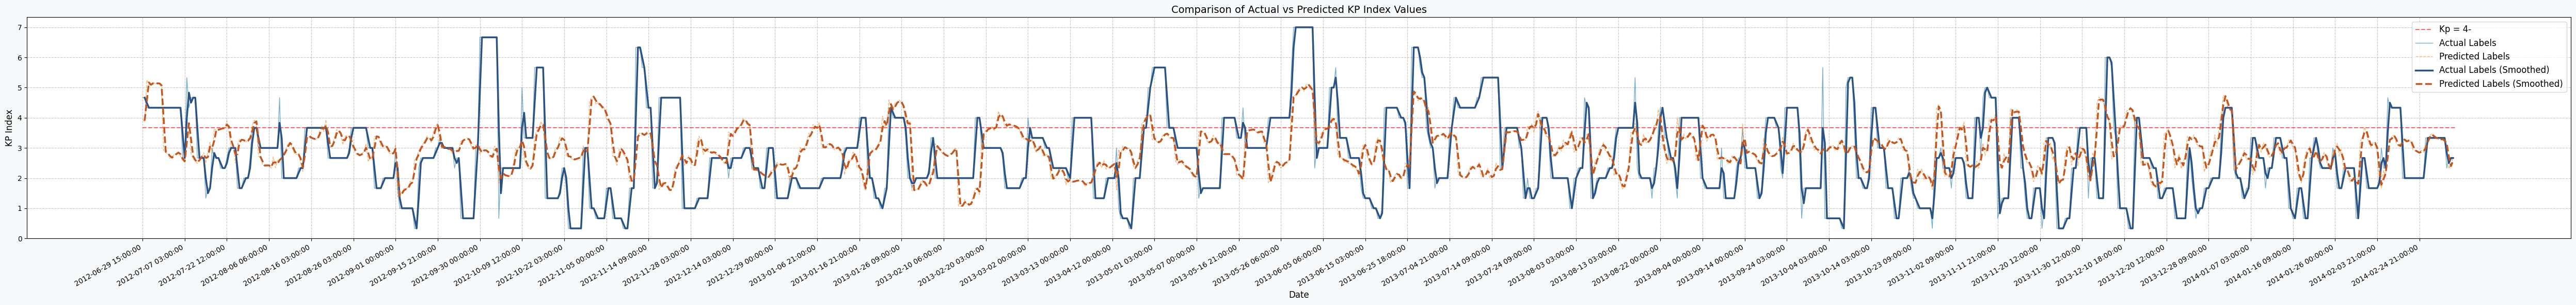

[np.float32(3.953125), np.float32(3.859375), np.float32(5.25), np.float32(5.09375), np.float32(5.09375), np.float32(5.1875), np.float32(5.125), np.float32(5.15625), np.float32(5.125), np.float32(5.03125), np.float32(2.90625), np.float32(2.84375), np.float32(2.8125), np.float32(2.65625), np.float32(2.703125), np.float32(2.78125), np.float32(2.8125), np.float32(2.875), np.float32(2.71875), np.float32(2.578125), np.float32(2.53125), np.float32(3.859375), np.float32(3.78125), np.float32(2.8125), np.float32(2.640625), np.float32(2.5625), np.float32(2.484375), np.float32(2.703125), np.float32(2.703125), np.float32(2.84375), np.float32(2.5), np.float32(2.890625), np.float32(3.1875), np.float32(2.828125), np.float32(3.640625), np.float32(3.578125), np.float32(3.625), np.float32(3.625), np.float32(3.671875), np.float32(3.640625), np.float32(3.90625), np.float32(3.515625), np.float32(3.015625), np.float32(3.109375), np.float32(2.5), np.float32(3.078125), np.float32(3.296875), np.float32(3.25), n

Testing Progress:   0%|          | 0/151 [00:00<?, ?it/s]

Average test loss: 2.9789
RMSE: 1.7259
MSE: 2.9789
MAE: 1.4512
R²: -2.7838
R: 0.2832


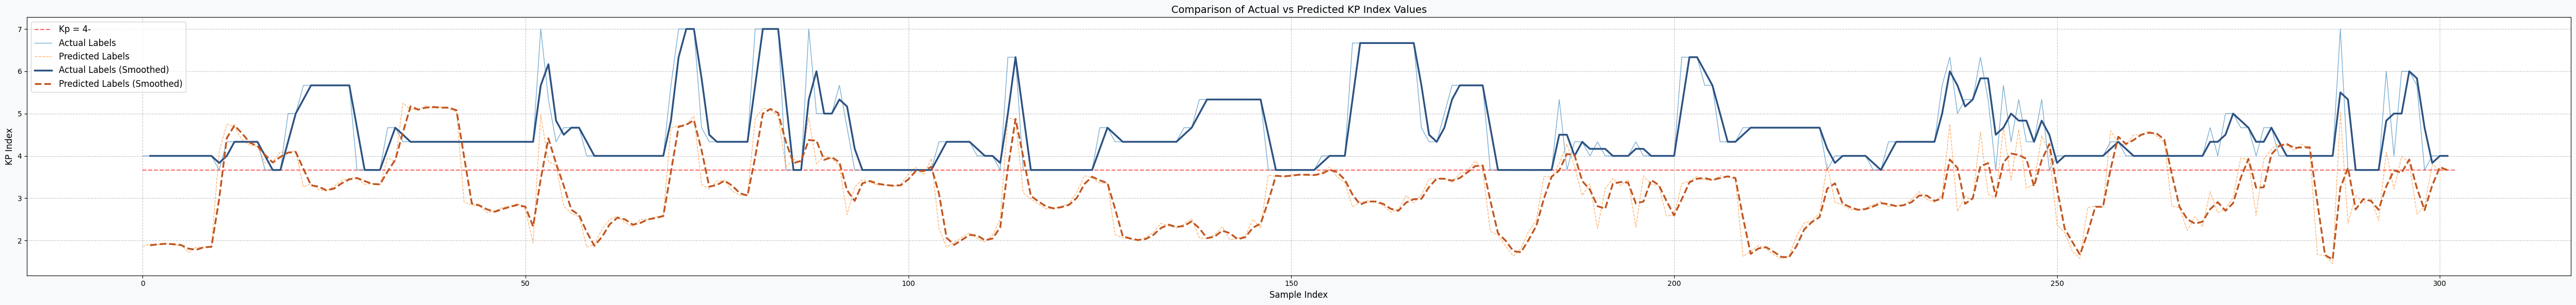

[np.float32(1.859375), np.float32(1.9140625), np.float32(1.90625), np.float32(1.9375), np.float32(1.890625), np.float32(1.8984375), np.float32(1.71875), np.float32(1.84375), np.float32(1.8359375), np.float32(1.8671875), np.float32(4.09375), np.float32(4.75), np.float32(4.6875), np.float32(4.375), np.float32(4.25), np.float32(4.21875), np.float32(3.828125), np.float32(3.859375), np.float32(4.09375), np.float32(4.0625), np.float32(4.125), np.float32(3.265625), np.float32(3.34375), np.float32(3.203125), np.float32(3.171875), np.float32(3.28125), np.float32(3.421875), np.float32(3.46875), np.float32(3.484375), np.float32(3.328125), np.float32(3.34375), np.float32(3.3125), np.float32(3.953125), np.float32(3.859375), np.float32(5.25), np.float32(5.09375), np.float32(5.09375), np.float32(5.1875), np.float32(5.125), np.float32(5.15625), np.float32(5.125), np.float32(5.03125), np.float32(2.90625), np.float32(2.84375), np.float32(2.8125), np.float32(2.65625), np.float32(2.703125), np.float32(2.7

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.1560275154153534


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7886672713954972


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.679921699992905


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7117240465685508


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3853013795088225


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9297570355384381


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1805437471618185


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.701557827624662


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9436634426638044


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.002245054628619


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7139815417259323


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.689731291816095


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5543689901324902


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9014130843561974


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4699786317523624


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8669096159859848


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3969364143498217


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.063652356947647


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.32891809691622037


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7810380889040607


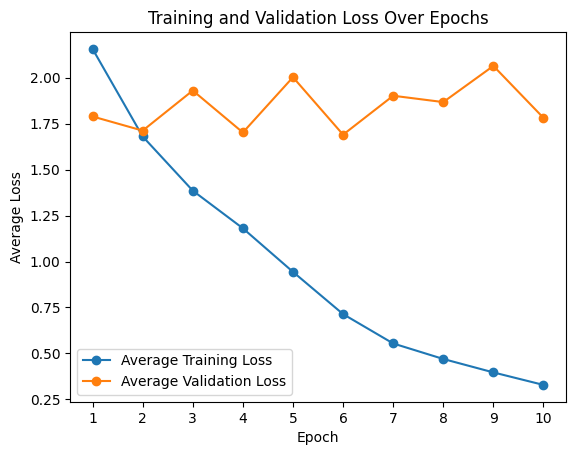

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.7810
RMSE: 1.3346
MSE: 1.7811
MAE: 1.0324
R²: 0.0353
R: 0.3102
True Skill Score: 0.4574
Accuracy: 0.6326
Precision: 0.5500
Recall: 0.1847
F1 Score: 0.2765


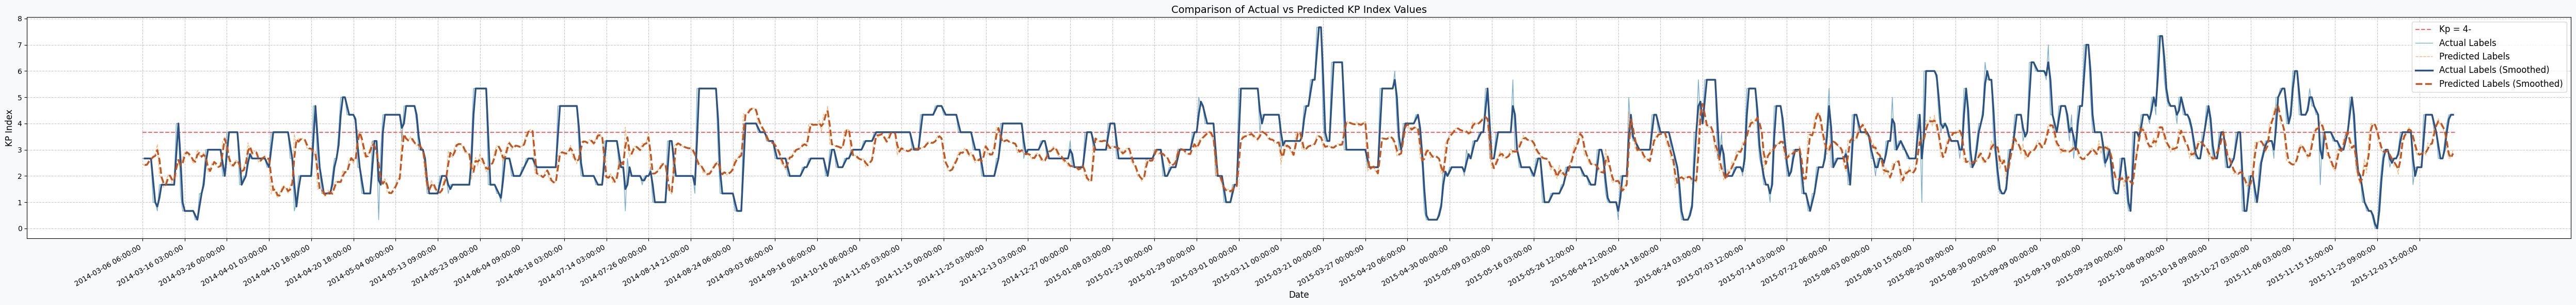

[np.float32(2.46875), np.float32(2.375), np.float32(2.46875), np.float32(2.609375), np.float32(2.671875), np.float32(2.765625), np.float32(2.765625), np.float32(3.203125), np.float32(2.046875), np.float32(1.8828125), np.float32(1.5703125), np.float32(1.734375), np.float32(2.046875), np.float32(1.984375), np.float32(1.734375), np.float32(1.9140625), np.float32(2.65625), np.float32(2.5625), np.float32(2.25), np.float32(2.703125), np.float32(2.890625), np.float32(2.921875), np.float32(2.765625), np.float32(2.734375), np.float32(2.46875), np.float32(2.609375), np.float32(3.0), np.float32(2.765625), np.float32(2.703125), np.float32(2.90625), np.float32(2.53125), np.float32(2.15625), np.float32(2.21875), np.float32(2.5), np.float32(2.5625), np.float32(2.359375), np.float32(2.328125), np.float32(2.4375), np.float32(3.328125), np.float32(3.5), np.float32(2.8125), np.float32(2.578125), np.float32(2.359375), np.float32(2.421875), np.float32(2.59375), np.float32(2.578125), np.float32(2.28125), np

Testing Progress:   0%|          | 0/209 [00:00<?, ?it/s]

Average test loss: 2.9576
RMSE: 1.7198
MSE: 2.9606
MAE: 1.4351
R²: -2.9949
R: 0.1190


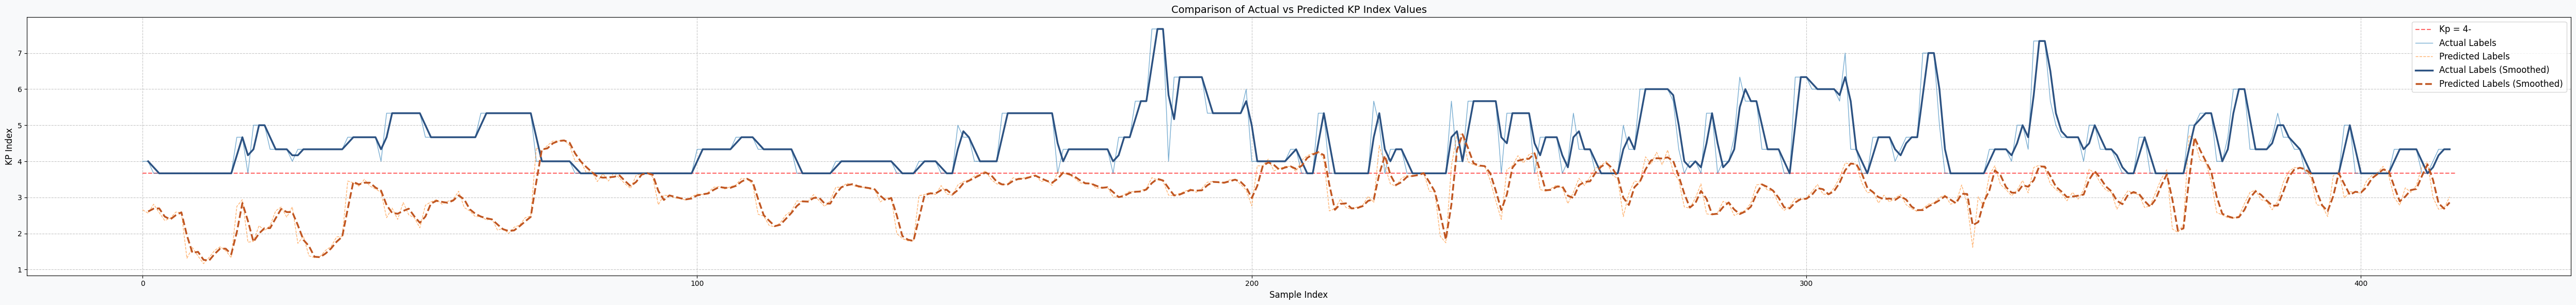

[np.float32(2.65625), np.float32(2.5625), np.float32(2.8125), np.float32(2.578125), np.float32(2.359375), np.float32(2.421875), np.float32(2.59375), np.float32(2.578125), np.float32(1.3125), np.float32(1.609375), np.float32(1.375), np.float32(1.1640625), np.float32(1.3359375), np.float32(1.53125), np.float32(1.6328125), np.float32(1.5234375), np.float32(1.328125), np.float32(2.75), np.float32(2.9375), np.float32(1.7578125), np.float32(1.78125), np.float32(2.21875), np.float32(2.078125), np.float32(2.21875), np.float32(2.625), np.float32(2.734375), np.float32(2.453125), np.float32(2.734375), np.float32(1.7265625), np.float32(1.921875), np.float32(1.3828125), np.float32(1.328125), np.float32(1.359375), np.float32(1.53125), np.float32(1.640625), np.float32(1.90625), np.float32(1.9140625), np.float32(3.453125), np.float32(3.40625), np.float32(3.3125), np.float32(3.5), np.float32(3.3125), np.float32(3.234375), np.float32(3.140625), np.float32(2.4375), np.float32(2.703125), np.float32(2.3906

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.2264237335074935


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.669289096157128


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.78528303118332


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6761865702667442


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.4338258155737738


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4681250621520792


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.097980163958489


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7402623103832306


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7755202596430117


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4342201851091632


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5817276893546625


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4158915393364078


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4165451842716737


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4698541671245906


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3632689882479948


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5106023344801203


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.31231990044254754


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4346200774774933


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.26848422386170395


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.440253383971345


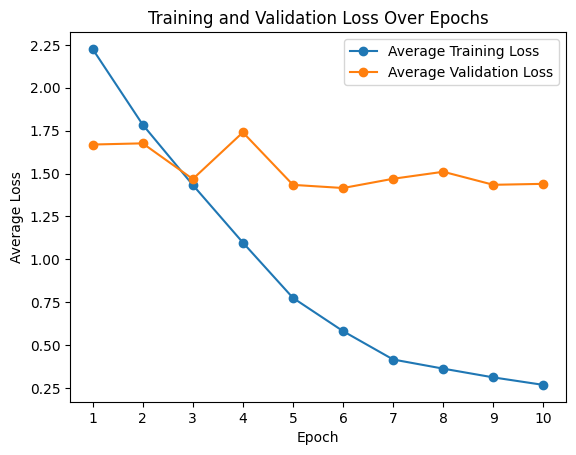

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.4403
RMSE: 1.2001
MSE: 1.4347
MAE: 0.9519
R²: 0.1475
R: 0.4214
True Skill Score: 0.5958
Accuracy: 0.7046
Precision: 0.7025
Recall: 0.4028
F1 Score: 0.5120


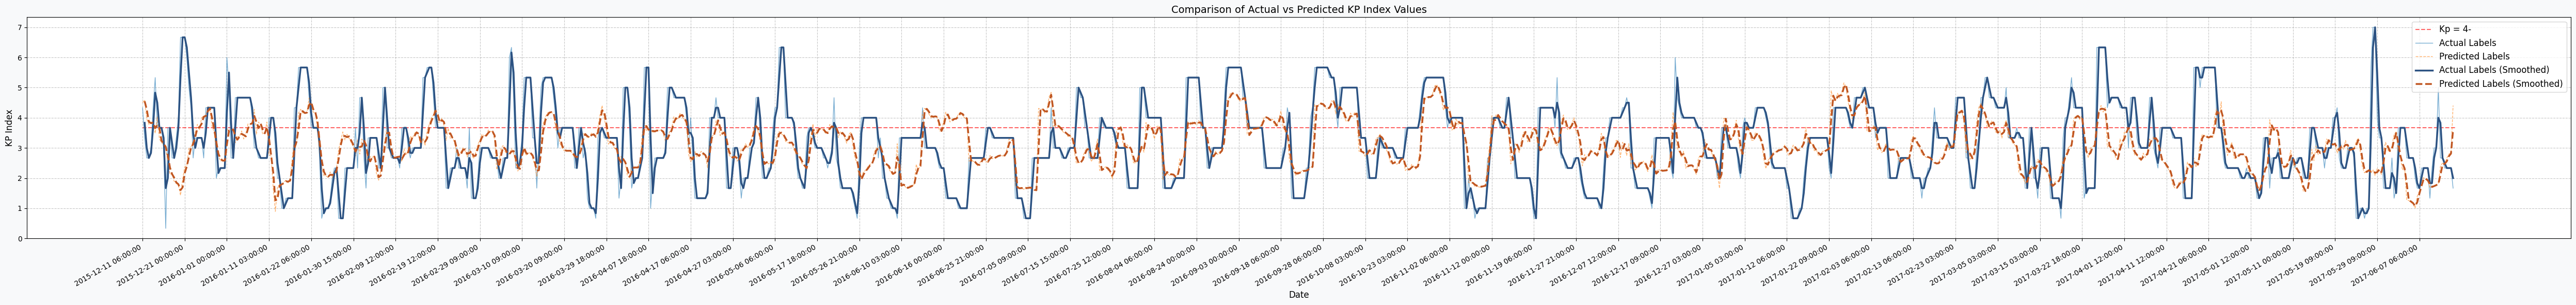

[np.float32(4.5), np.float32(4.59375), np.float32(3.953125), np.float32(3.78125), np.float32(3.859375), np.float32(3.828125), np.float32(3.484375), np.float32(4.03125), np.float32(3.296875), np.float32(3.171875), np.float32(3.125), np.float32(2.9375), np.float32(2.578125), np.float32(2.125), np.float32(2.140625), np.float32(1.890625), np.float32(1.8203125), np.float32(1.7734375), np.float32(1.4296875), np.float32(1.953125), np.float32(2.375), np.float32(2.40625), np.float32(2.984375), np.float32(3.03125), np.float32(3.21875), np.float32(3.515625), np.float32(3.78125), np.float32(3.59375), np.float32(4.0), np.float32(4.0625), np.float32(4.0625), np.float32(4.375), np.float32(4.25), np.float32(3.71875), np.float32(3.515625), np.float32(2.875), np.float32(2.734375), np.float32(2.5625), np.float32(2.59375), np.float32(2.5625), np.float32(3.65625), np.float32(3.5), np.float32(3.625), np.float32(3.609375), np.float32(3.171875), np.float32(3.375), np.float32(3.375), np.float32(3.5625), np.flo

Testing Progress:   0%|          | 0/211 [00:00<?, ?it/s]

Average test loss: 1.9343
RMSE: 1.3908
MSE: 1.9343
MAE: 1.1291
R²: -2.3410
R: 0.2840


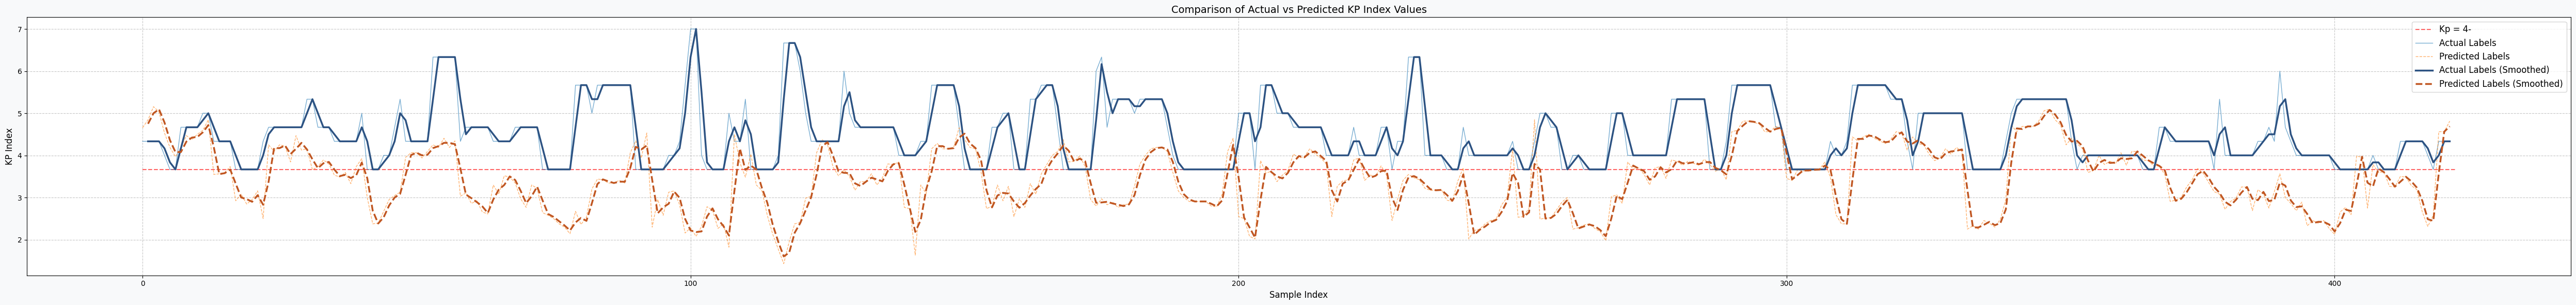

[np.float32(4.65625), np.float32(4.84375), np.float32(5.15625), np.float32(5.03125), np.float32(4.53125), np.float32(4.1875), np.float32(3.96875), np.float32(4.1875), np.float32(4.46875), np.float32(4.375), np.float32(4.5), np.float32(4.59375), np.float32(4.84375), np.float32(3.546875), np.float32(3.5625), np.float32(3.59375), np.float32(3.734375), np.float32(2.921875), np.float32(3.078125), np.float32(2.84375), np.float32(2.953125), np.float32(3.15625), np.float32(2.5), np.float32(4.25), np.float32(4.09375), np.float32(4.25), np.float32(4.21875), np.float32(3.84375), np.float32(4.46875), np.float32(4.125), np.float32(4.15625), np.float32(3.65625), np.float32(3.734375), np.float32(3.890625), np.float32(3.796875), np.float32(3.53125), np.float32(3.484375), np.float32(3.59375), np.float32(3.328125), np.float32(3.734375), np.float32(3.921875), np.float32(3.0), np.float32(2.375), np.float32(2.390625), np.float32(2.671875), np.float32(2.953125), np.float32(3.046875), np.float32(3.125), np.f

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.2347584475843583


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.8768679465658682


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.765362934924188


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4885049894420346


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.4781371580899967


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5290675452022433


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.190533218602114


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4290758881450165


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.9529515209863745


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4746761925058143


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.7500958528265984


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5089238180535507


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.5089908260843874


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5141291957426901


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.39157541163205006


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5313125535769558


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3306051771507079


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.569971993593499


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.2765696541488962


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.41116644740528


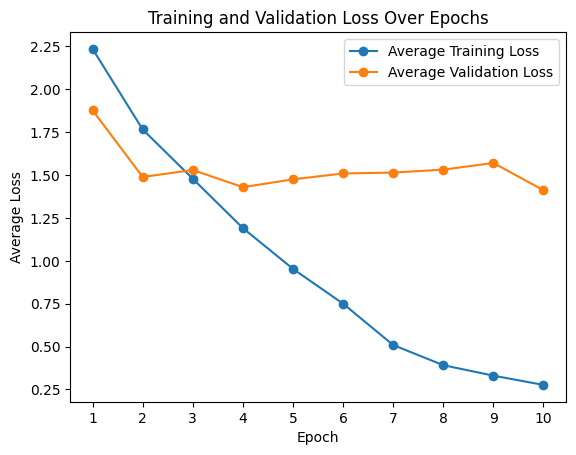

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 1.4112
RMSE: 1.1879
MSE: 1.4120
MAE: 0.9316
R²: 0.1329
R: 0.4063
True Skill Score: 0.4830
Accuracy: 0.7389
Precision: 0.5829
Recall: 0.3428
F1 Score: 0.4317


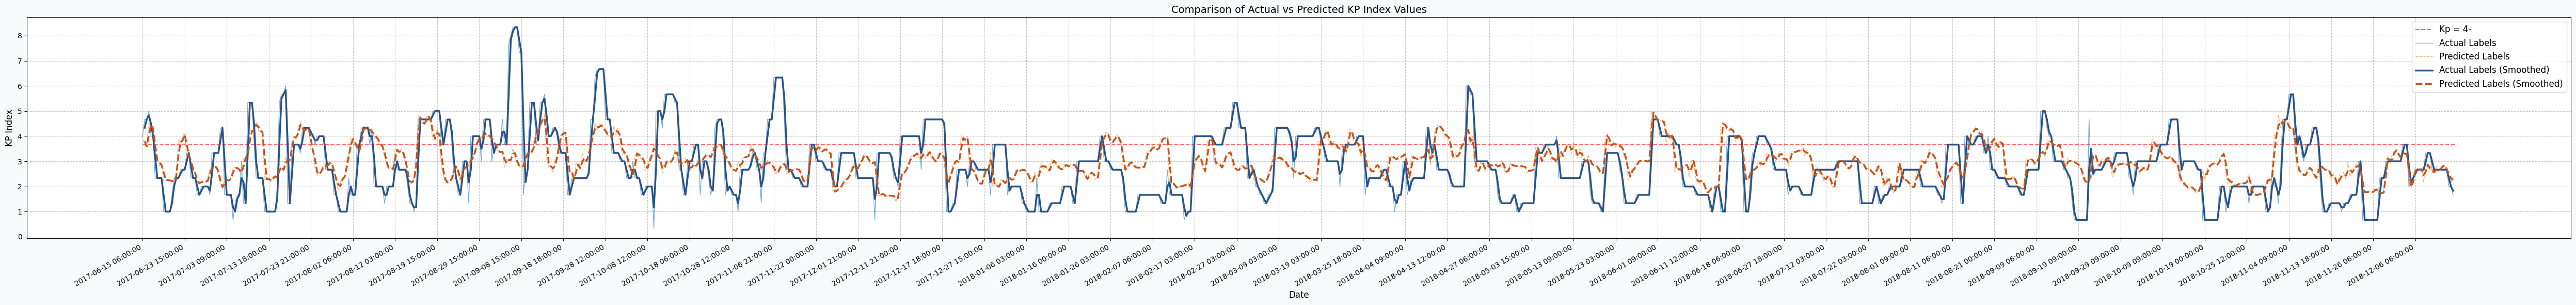

[np.float32(4.0), np.float32(3.59375), np.float32(3.59375), np.float32(4.53125), np.float32(4.34375), np.float32(4.28125), np.float32(3.015625), np.float32(3.078125), np.float32(2.828125), np.float32(2.890625), np.float32(2.234375), np.float32(2.296875), np.float32(2.203125), np.float32(2.28125), np.float32(2.15625), np.float32(2.265625), np.float32(2.53125), np.float32(3.859375), np.float32(3.671875), np.float32(3.984375), np.float32(4.125), np.float32(3.21875), np.float32(3.28125), np.float32(2.71875), np.float32(2.71875), np.float32(2.375), np.float32(2.0625), np.float32(2.1875), np.float32(2.15625), np.float32(2.203125), np.float32(2.171875), np.float32(2.28125), np.float32(2.734375), np.float32(2.734375), np.float32(2.78125), np.float32(2.765625), np.float32(2.453125), np.float32(2.046875), np.float32(1.9140625), np.float32(2.28125), np.float32(2.25), np.float32(2.21875), np.float32(2.375), np.float32(2.734375), np.float32(2.75), np.float32(2.71875), np.float32(2.625), np.float32(

Testing Progress:   0%|          | 0/159 [00:00<?, ?it/s]

Average test loss: 2.1711
RMSE: 1.4734
MSE: 2.1711
MAE: 1.1186
R²: -1.9180
R: 0.1171


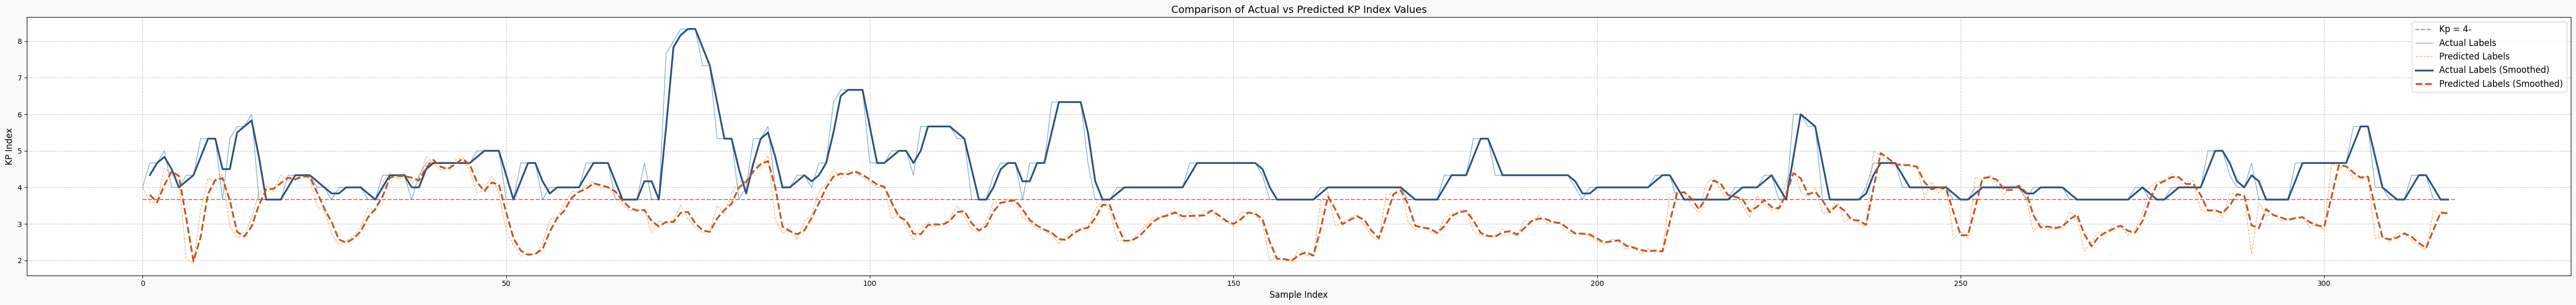

[np.float32(4.0), np.float32(3.59375), np.float32(3.59375), np.float32(4.53125), np.float32(4.34375), np.float32(4.28125), np.float32(2.046875), np.float32(1.9140625), np.float32(3.390625), np.float32(4.25), np.float32(4.15625), np.float32(4.34375), np.float32(2.9375), np.float32(2.625), np.float32(2.6875), np.float32(3.171875), np.float32(3.859375), np.float32(4.03125), np.float32(3.890625), np.float32(4.34375), np.float32(4.1875), np.float32(4.25), np.float32(4.34375), np.float32(4.25), np.float32(3.46875), np.float32(3.375), np.float32(2.71875), np.float32(2.4375), np.float32(2.53125), np.float32(2.671875), np.float32(2.921875), np.float32(3.4375), np.float32(3.375), np.float32(4.125), np.float32(4.40625), np.float32(4.21875), np.float32(4.40625), np.float32(4.125), np.float32(4.25), np.float32(4.84375), np.float32(4.65625), np.float32(4.46875), np.float32(4.53125), np.float32(4.75), np.float32(4.8125), np.float32(4.4375), np.float32(3.84375), np.float32(3.953125), np.float32(4.3125

In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='gpu', devices=1, precision="bf16-mixed")
fabric.launch(train_model)
# print(fabric.device)


In [ ]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
